In [25]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cmapss
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow_probability import distributions
from sklearn.metrics import r2_score

# Load data
data_folder = '/app/data'
data = cmapss.load_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# Focus on a subset of the data
data_by_src = cmapss.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = cmapss.partition_by_machine(dt, tr_mcn)

# Standardization and normalization
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

trmaxrul = tr['rul'].max()
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

# Define a cost model
failtimes = dt.groupby('machine')['cycle'].max()
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()
cmodel = cmapss.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Sliding window input
wlen = 3
tr_sw, tr_sw_m, tr_sw_r = cmapss.sliding_window_by_machine(tr_s, wlen, dt_in)
ts_sw, ts_sw_m, ts_sw_r = cmapss.sliding_window_by_machine(ts_s, wlen, dt_in)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RUL Prediction as Classification

## RUL Prediction as Classification

**RUL-based maintenance can also be tackled _using a classifier_**

* We build a classifier to determine whether a failure will occur in $\theta$ steps
* We stop as soon as the classifier outputs (say) a 0, i.e.

$$
f_\theta(x, \lambda) = 0
$$

* $f$ is the classifier, with parameter vector $\lambda$
* $\theta$ is the horizon for detecting a failure

**In a sense, we are trying to learn _directly_ a maintenance policy**

* The policy is the form "stop $\theta$ units before a failure"
* The classifier tries to learn it

## Classifier Architecture

**We can therefore immediately define our classifier architecture:**

In [27]:
def build_classifier(hidden):
    input_shape = (len(dt_in), )
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    model_out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(model_in, model_out)
    return model

* Like in the regression case, we use a Multilayer Perceptron
* The only difference is the use of a sigmoid activation in the output layer
* For `hidden = []` we get Logistic Regression

## Training

**Before training, we need to define the classes**

In turn, this requires to define the detection horizon $\theta$:

In [28]:
class_thr = 15
tr_lbl = (tr['rul'] >= class_thr)
ts_lbl = (ts['rul'] >= class_thr)

* The class is "1" if a failure is more than $\theta$ steps away
* The class if "0" otherwise

**Classification problems _tend to be easier_ than regression problems**

* On the other hand, learning the whole policy
* ...May be trickier than just estimating the RUL 


## Training

**Let's start by training the simplest possible model**

In [29]:
nn1 = build_classifier(hidden=[])
nn1.compile(optimizer='Adam', loss='binary_crossentropy')
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history1 = nn1.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 1s 977us/step - loss: 0.5694 - val_loss: 0.3964
Epoch 2/20
1135/1135 [==============================] - 1s 855us/step - loss: 0.3222 - val_loss: 0.2823
Epoch 3/20
1135/1135 [==============================] - 1s 849us/step - loss: 0.2466 - val_loss: 0.2394
Epoch 4/20
1135/1135 [==============================] - 1s 872us/step - loss: 0.2165 - val_loss: 0.2219
Epoch 5/20
1135/1135 [==============================] - 1s 865us/step - loss: 0.2029 - val_loss: 0.2131
Epoch 6/20
1135/1135 [==============================] - 1s 907us/step - loss: 0.1950 - val_loss: 0.2065
Epoch 7/20
1135/1135 [==============================] - 1s 854us/step - loss: 0.1890 - val_loss: 0.2011
Epoch 8/20
1135/1135 [==============================] - 1s 850us/step - loss: 0.1838 - val_loss: 0.1961
Epoch 9/20
1135/1135 [==============================] - 1s 860us/step - loss: 0.1794 - val_loss: 0.1920
Epoch 10/20
1135/1135 [==============================] - 1s 861u

## Training

**Here's the loss evolution over time and its final value**

Final loss: 0.1518 (training), 0.1652 (validation)


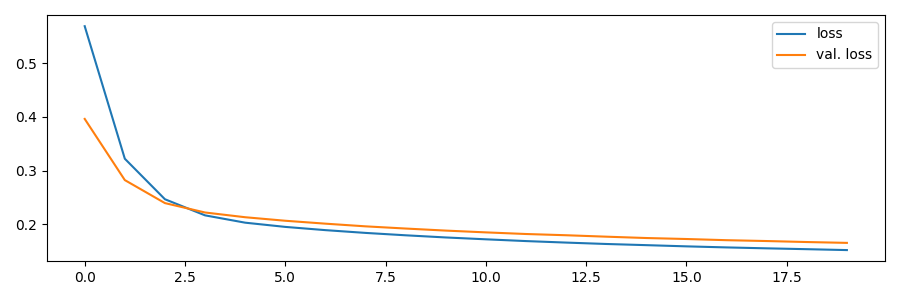

In [30]:
cmapss.plot_training_history(history1, figsize=figsize)
tr1, vl1 = history1.history["loss"][-1], np.min(history1.history["val_loss"])
print(f'Final loss: {tr1:.4f} (training), {vl1:.4f} (validation)')

## Training

**Let's try with a deeper model**

In [31]:
nn2 = build_classifier(hidden=[32, 32])
nn2.compile(optimizer='Adam', loss='binary_crossentropy')
history2 = nn2.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 2s 1ms/step - loss: 0.1904 - val_loss: 0.1542
Epoch 2/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.1310 - val_loss: 0.1209
Epoch 3/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.1050 - val_loss: 0.0975
Epoch 4/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0919 - val_loss: 0.0910
Epoch 5/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0844 - val_loss: 0.0748
Epoch 6/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0797 - val_loss: 0.0795
Epoch 7/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0757 - val_loss: 0.0706
Epoch 8/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0754 - val_loss: 0.0705
Epoch 9/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.0738 - val_loss: 0.0757
Epoch 10/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.074

## Training

**Here's the loss for the deeper model**

Final loss: 0.0688 (training), 0.0600 (validation)


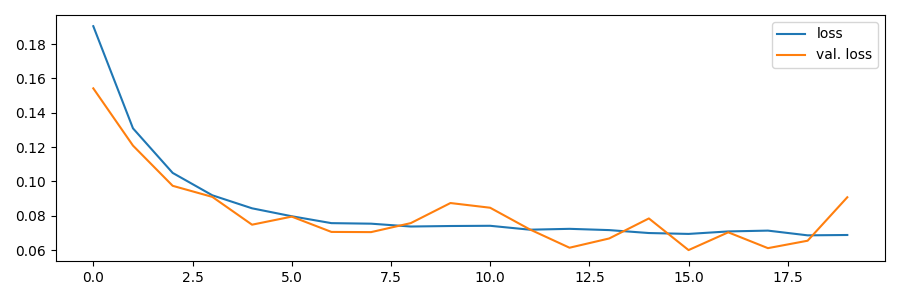

In [32]:
cmapss.plot_training_history(history2, figsize=figsize)
tr2, vl2 = history2.history["loss"][-1], np.min(history2.history["val_loss"])
print(f'Final loss: {tr2:.4f} (training), {vl2:.4f} (validation)')

* Depth pays off big in this case

## Predictions

**Our predictions can be interpreted as probabilities (of advancing)**

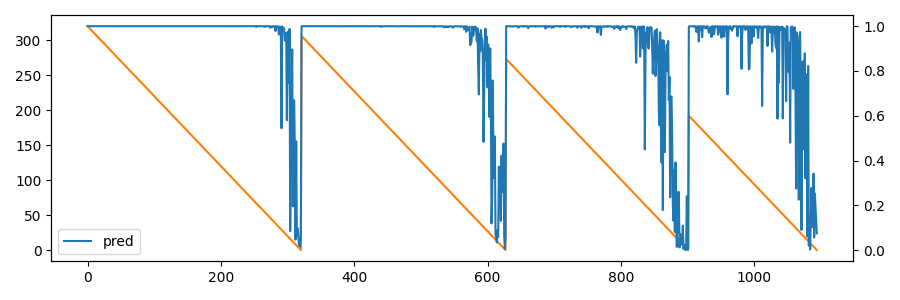

In [33]:
tr_pred2_prob = nn2.predict(tr_s[dt_in]).ravel()
stop = 1095
cmapss.plot_rul(tr_pred2_prob[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

* The probability falls when closer to failures

## Predictions

**In practice, we need to convert the predictions to integers via rounding**

...Unless we want to deal with one more threshold (in addition to $\theta$)

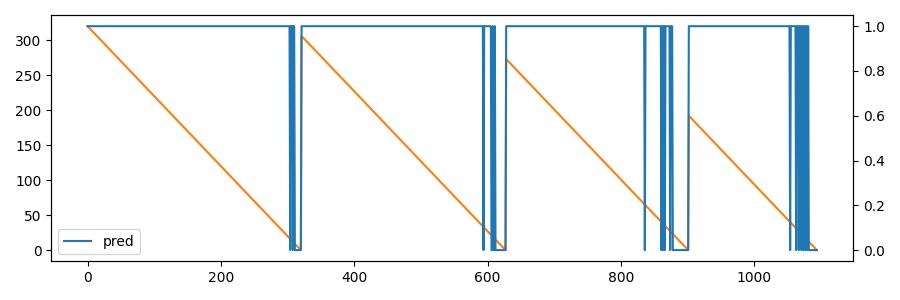

In [35]:
tr_pred2 = np.round(nn2.predict(tr_s[dt_in]).ravel())
cmapss.plot_rul(tr_pred2[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

* Still, the behavior seems to be reasonable

## Predictions

**Let's see the behavior on the test set**

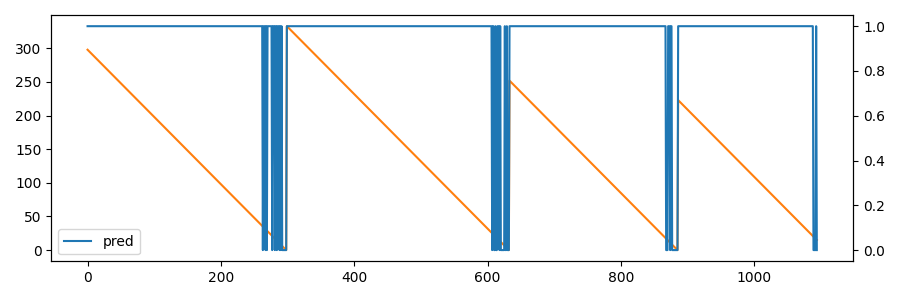

In [36]:
ts_pred2 = np.round(nn2.predict(ts_s[dt_in]).ravel())
cmapss.plot_rul(ts_pred2[:stop], ts['rul'][:stop], same_scale=False, figsize=figsize)

* Apparently a decent degree of generalization

## Evaluation

**We can evaluate the classifier _directly_**

...Because it defines the whole policy, with no need for additional calibration!

* On one hand this makes this stage of the process _simpler_
* ...On the other, this is (apparently) a missed opportunity

In [37]:
tr_c2, tr_f2, tr_s2 = cmodel.cost(tr['machine'].values, tr_pred2, 0.5, return_margin=True)
ts_c2, ts_f2, ts_s2 = cmodel.cost(ts['machine'].values, ts_pred2, 0.5, return_margin=True)
print(f'Cost: {tr_c2} (training), {ts_c2} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn)} (training), {ts_f2/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s2/len(tr_mcn):.2f} (training), {ts_s2/len(ts_mcn):.2f} (test)')

Cost: -14888 (training), -5706 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 37.49 (training), 34.81 (test)


* Still pretty good results, but worse than the best regression approach
* We will investigate _two potential reasons_

# Balancing a Dataset

## Balancing a Dataset

**By construction, our dataset is likely to be strongly unbalanced**

In [38]:
counts = tr_lbl.value_counts(normalize=True)
counts

True     0.938526
False    0.061474
Name: rul, dtype: float64

* In these kind of situation, SGD optimization may have convergence issues
* The gradient will push strongly in the direction of the overrepresented class

**A common practice to address this issue is using _class weights_**

* Typically, we use weights inversely proportional to the counts
* ...So as to counter-balance the effect

In [39]:
class_weight = {0: 1/counts[0], 1: 1/counts[1]}

## Class-Weights, Cross-Entropy, and Likelihood

**While are class frequencies typically used as weights?**

Let's say our classifier is trained via for _weighted cross-entropy_:
$$
\min_{y} \left\{ - w_1 \sum_{\hat{y}_i = 1} \log y_i -  w_0 \sum_{\hat{y}_i = 0} \log (1 - y_i) \right\}
$$
* Where $\hat{y}$ is the label vector and $y$ the vector of classifier outputs
* $w_0$ and $w_1$ are the weights for class 0 and 1

**If we switch optimization direction and we apply an exponential we get:**
$$
\max_{y} \left\{ e^{w_1 \sum_{\hat{y}_i = 1} \log y_i} e^{w_0 \sum_{\hat{y}_i = 0} \log (1 - y_i)} \right\}
$$
* The _optimal points_ are the same as before

## Class-Weights, Cross-Entropy, and Likelihood

**We with algebraic manipulations we finally obtain:**

$$
\max_{y} \left\{ \prod_{\hat{y}_i = 1} y_i^{w_1} \prod_{\hat{y}_i = 0} (1-y_i)^{w_0} \right\}
$$

**When training, we are _maximizing a likelihood expression_!**

* To see that, just interpret $y_i$ as the (estimated) probability of the class being 1

**The weights act as _exponents for the class probabilities_**

...Which is equivalent to adjusting their frequencies!

* E.g. from a mathematical point of view, setting $w_0$ to 2...
* ...Is equivalent to making a copy of each example having label 0

Hence, inverse class frequencies are often used as weights for dataset rebalancing

## Training with Non-uniform Class Weights

**Let's repeat the training process**

In [40]:
nn3 = build_classifier(hidden=[32, 32])
nn3.compile(optimizer='Adam', loss='binary_crossentropy')
history3 = nn3.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                 callbacks=cb, class_weight=class_weight,
                 batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 2s 1ms/step - loss: 1.0195 - val_loss: 0.2871
Epoch 2/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.5913 - val_loss: 0.2095
Epoch 3/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.4221 - val_loss: 0.2141
Epoch 4/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.3681 - val_loss: 0.1875
Epoch 5/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.3339 - val_loss: 0.1400
Epoch 6/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.3179 - val_loss: 0.1421
Epoch 7/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.3012 - val_loss: 0.3519
Epoch 8/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.2880 - val_loss: 0.1716
Epoch 9/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.2920 - val_loss: 0.2023
Epoch 10/20
1135/1135 [==============================] - 1s 1ms/step - loss: 0.285

## Predictions

**Let's check how the the raw predictions (probabilities) have changed**

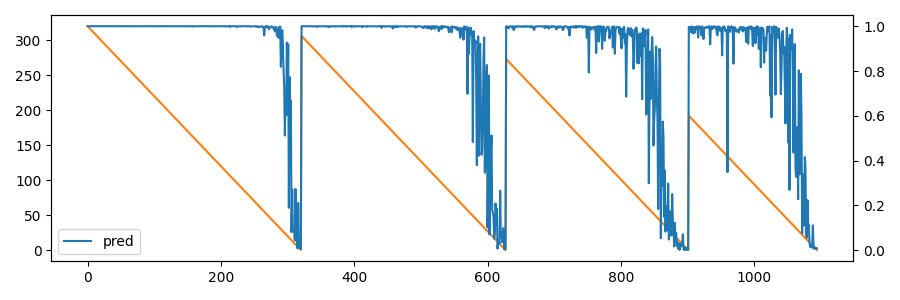

In [41]:
tr_pred3_prob = nn3.predict(tr_s[dt_in]).ravel()
cmapss.plot_rul(tr_pred3_prob[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

* They have actually become _worse_: there are mistakes in the initial section

## Evaluation

**Let's check the model performance in terms of cost**

In [42]:
tr_pred3 = np.round(nn3.predict(tr_s[dt_in]).ravel())
ts_pred3 = np.round(nn3.predict(ts_s[dt_in]).ravel())
tr_c3, tr_f3, tr_s3 = cmodel.cost(tr['machine'].values, tr_pred3, 0.5, return_margin=True)
ts_c3, ts_f3, ts_s3 = cmodel.cost(ts['machine'].values, ts_pred3, 0.5, return_margin=True)
print(f'Cost: {tr_c3} (training), {ts_c3} (test)')
print(f'Avg. fails: {tr_f3/len(tr_mcn)} (training), {ts_f3/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s3/len(tr_mcn):.2f} (training), {ts_s3/len(ts_mcn):.2f} (test)')

Cost: -14294 (training), -5481 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 41.77 (training), 38.24 (test)


As expected, the results are worse

* The model now treats the two classes more fairly
* ...But this increases the chance of an (undesirable) early stop

**So, how shall we choose the balance?**

# Bayesian (Surrogate-Based) Optimization

## Taking a Step Back

**In the _regression_ case, we are formally solving:**

$$\begin{align}
&\min_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \lambda^*), \theta) \\
\text{ with: } \lambda^* &= \text{argmin}_\lambda L(f(x_k, \lambda), y_k)
\end{align}$$

* Where $\lambda^*$ is the optimal parameter vector (i.e. the network weights)
* ...And $L$ is the loss function (i.e. the MSE), and $\mathit{cost}$ is our cost model
* $\theta$ is chosen so as to minimize the cost

**This is a _bilevel optimization_ problem**

* However, since $\theta$ does appears neither in $L$ nor in $f$
* ...It can be _decomposed into two sequential subproblems_

## Taking a Step Back

**In the _classification_ case, we are formally solving:**

$$\begin{align}
&\text{min}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \lambda^*), 0.5) \\
\text{ with: } \lambda^* &= \text{argmin}_\lambda L(f(x_k, \lambda), {\bf 1}_{y_k \geq \theta})
\end{align}$$

* In this case, we use a dummy threshold in the cost model (i.e. 0.5)
* ...And ${\bf 1}_{y_k \geq \theta}$ is the indicator function of $y_k \geq \theta$ (i.e. our class labels)

**Unlike the previous one, this problem _cannot be decomposed_**

...Because $\theta$ appears in the loss function!

* This means we need to _optimize $\theta$ and $\lambda$ at the same time_
* This is obviously complicated, but it's also an _opportunity_
* ...Since we can _adapt the training problem_ based on the threshold

## Taking a Step Back

**We can try to tackle the optimization process in a hierarchical fashion**

1. We search over the possible values of $\theta$
2. For the given $\theta$ value, we compute ${\bf 1}_{y_k \geq \theta}$ (i.e. the class labels)
3. For the given $\theta$ and ${\bf 1}_{y_k \geq \theta}$, we compute $\lambda^*$ (i.e. we train the model)
4. For the given $\theta$, ${\bf 1}_{y_k \geq \theta}$, and $\lambda^*$, we compute the cost

At the end of the process, we choose the configuration with the best cost

**The method is reasonable, but slow**

* We could reduce the runtime by warm-starting each training attempt
* ...And by searching over $\theta$ in a smart way

## Bayesian Optimization

**We will use an approach known as _Bayesian optimization_**

* It's actually a family of _surrogate-based optimization_ methods
* They are all designed to optimize _blackbox functions_
* I.e. functions with an unknown structure, that can only be evaluated

**Formally, they address problems in the form:**

$$
\min_{x \in B} f(x)
$$

* Where $B$ is a box, i.e. a specification of bounds for each component of $x$

In our case:

* The decision variable $x$ would be $\theta$
* The function to be optimized would be the cost

## Bayesian (or Surrogate-Based) Optimization

**Internally, methods in this family store:**

* A collection $\hat{x}$ of evaluated points
* A surrogate-model $\tilde{f}$ for $f$

**The basic loop of the algorithm is then as follow:**

Let $x^*$ be the current candidate optimum

* Based on the current $\tilde{f}$:
  - Determine whether there exists $x^\prime \in B$ that may improve over $x^*$
  - If there is no such point, return $x^*$
  - Otherwise
    + Evaluate $f(x^\prime)$ and possibly replace $x^*$
    + Add $x^\prime$ to $\hat{x}$, adjust $\tilde{f}$, and repeat

## Bayesian (or Surrogate-Based) Optimization

**A few considerations:**

In practice, the algorithm needs to balance _exploration_ and _exploitation_

* We need to explore regions where we cannot make confident predictions
* ...But we need also to focus on regions with promising cost values

**Different Bayesian optimization algorithms:**

* Make use of different surrogate models
* Rely on different criteria for choosing $x^\prime$
* Strike different trade-offs in terms of number of (expensive) evaluations of $f$
* ...And the quality of the obtained solutions

**For more information, see (e.g.) [this tutorial](https://machinelearningmastery.com/what-is-bayesian-optimization/)**

## Our Chosen Optimizer

**We will use the `bayesian-optimization` python module**

* The solver is designed for maximization
* Decent documentation can be found on [its github page](https://github.com/fmfn/BayesianOptimization)
* It's not as fast as (e.g.) [RBFOpt](https://github.com/coin-or/rbfopt), but easier to install and configure

**The solver relies on _Gaussian Processes_ as a surrogate model:**

GPs are guaranteed to (approximately) touch every point in the training set

* ...And behave reasonably well even with a simple RBF kernel
* ...Which is in fact the one used in this case

**GPs provide confidence intervals**

...Which the algorithm uses to balance exploration and exploitation

* Regions with wide C.I. may be worth exploring
* ...And regions with high (upper) C.I. may contain high-quality solutions

## Method Setup

**First, we need to define the function to be maximized**

This will be the (negative) cost, after retraining the classifier:

In [44]:
nn4 = build_classifier(hidden=[32, 32])
nn4.compile(optimizer='Adam', loss='binary_crossentropy')
nn4.set_weights(nn2.get_weights())

bo_weights = {}
def classification_obj(class_thr, class0_weight):
    # Define new labels
    tr_lbl = (tr['rul'] >= class_thr)
    # Fit
    nn4.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                     callbacks=cb, class_weight={1:1, 0:class0_weight},
                     batch_size=32, epochs=5, verbose=0)
    # Cost computation
    tr_pred = np.round(nn4.predict(tr_s[dt_in]).ravel())
    tr_cost = cmodel.cost(tr['machine'].values, tr_pred, 0.5)
    # Store the model weights
    bo_weights[class_thr, class0_weight] = nn4.get_weights()
    return -tr_cost

## Method Setup

**We rely on warm-starting to reduce the training time**

We start from (the weights of) our deep MLP

```python
nn4 = build_classifier(hidden=[32, 32])
nn4.compile(optimizer='Adam', loss='binary_crossentropy')
nn4.set_weights(nn2.get_weights())
```

...So that we can train for just a few epochs

```python
nn4.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                 callbacks=cb, class_weight={1:1, 0:class0_weight},
                 batch_size=32, epochs=5, verbose=0)
```

* Since the training process is stochastic...
* The optimization result will be stochastic as well

## Method Setup

**We will optimize _both $\theta$ and the class weights_**

```python
def classification_obj(class_thr, class0_weight):
    ...
    nn4.fit(tr_s[dt_in], tr_lbl, validation_split=0.2,
                     callbacks=cb, class_weight={1:1, 0:class0_weight},
                     batch_size=32, epochs=5, verbose=0)
    ...
```

* We can afford it, since we have a much better optimizer than grid search

**We need to store the weights of each model**

...So that we can recover the optimal configuration:

```python
bo_weights[class_thr, class0_weight] = nn4.get_weights()
```

## Method Setup

**We now define the bounding box**

In [46]:
box = {'class_thr': (1, 15), 'class0_weight': (1, 10)}

* We will consider stopping from 1 to 15 steps before a failure
* We will consider weights for class 0 from 1 to 10

**Then we can configure the optimizer:**

In [47]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(f=classification_obj,
                                 pbounds=box, random_state=42, verbose=2)

* We specify the function to be maximized, the box
* ...But also a random seed and the logging level

## Optimization

**Finally, we run the optimization process**

In [48]:
optimizer.maximize(n_iter=10, init_points=3)

|   iter    |  target   | class0... | class_thr |
-------------------------------------------------
|  1        |  1.56e+04 |  4.371    |  14.31    |
|  2        |  1.646e+0 |  7.588    |  9.381    |
|  3        |  1.847e+0 |  2.404    |  3.184    |
|  4        |  4.046e+0 |  5.981    |  1.159    |
|  5        |  1.894e+0 |  2.312    |  3.202    |
|  6        |  8.77e+03 |  1.0      |  4.871    |
|  7        |  1.702e+0 |  1.511    |  2.291    |
|  8        |  1.583e+0 |  6.548    |  10.98    |
|  9        |  1.46e+04 |  5.755    |  9.03     |
|  10       |  1.513e+0 |  8.572    |  10.88    |
|  11       |  1.646e+0 |  9.153    |  8.512    |
|  12       |  1.758e+0 |  7.75     |  7.521    |
|  13       |  1.784e+0 |  8.989    |  6.618    |


## Retrieving the Results

**We can access the best configuration via**

In [49]:
optimizer.max

{'target': 18938.0,
 'params': {'class0_weight': 2.312444657762272,
  'class_thr': 3.2024603154577833}}

Once we know the configuration, we can reconstruct the corresponding model: 

In [50]:
class_thr4 = optimizer.max['params']['class_thr']
class0_weight4 = optimizer.max['params']['class0_weight']
nn4.set_weights(bo_weights[class_thr4, class0_weight4])

* We do this by accessing the weights in the `bo_weights` dictionary

## Evaluation

**Finally, we can obtain the predictions**

In [51]:
tr_pred4 = np.round(nn4.predict(tr_s[dt_in]).ravel())
ts_pred4 = np.round(nn4.predict(ts_s[dt_in]).ravel())

...And we can evaluate the optimized model:

In [52]:
tr_c4, tr_f4, tr_s4 = cmodel.cost(tr['machine'].values, tr_pred4, 0.5, return_margin=True)
ts_c4, ts_f4, ts_s4 = cmodel.cost(ts['machine'].values, ts_pred4, 0.5, return_margin=True)
print(f'Cost: {tr_c4} (training), {ts_c4} (test)')
print(f'Avg. fails: {tr_f4/len(tr_mcn)} (training), {ts_f4/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s4/len(tr_mcn):.2f} (training), {ts_s4/len(ts_mcn):.2f} (test)')

Cost: -18938 (training), -6513 (test)
Avg. fails: 0.0 (training), 0.015873015873015872 (test)
Avg. slack: 14.24 (training), 11.49 (test)


* We are now on-par with the best regression based approaches!
* Actual results may be slightly better or worse due to randomness

## Considerations

**Why choosing a classification-based approach?**

* In some cases, classification can be _easier_ than regression
* The threshold affects training, which is computationally heavier
* ...But it means that training can _adapt to the threshold_

**We we tackle the prediction and cost optimization stages in isolation:**

* The two stages are "glued" by the ML loss (MSE or cross-entropy)
* ....But the loss does not penalize mistakes based on their (economic) cost!
* Ideally, an end-to-end cost optimization approach should work better
  
**Bayesian/surrogate-based optimization can have many uses**

* Hyper-parameter optimization
* Fitting simulation models
* Optimizing equipment setpoints (e.g. Air Conditioning), based on simulation
* ...